# Advanced Certification Program in Computational Data Science
## A program by IISc and TalentSprint
### Mini Project: Implementation of Linear Regression on a Large Dataset Using Dask Library

## Learning Objectives

At the end of the mini-project, you will be able to :

- understand how dask handles large dataset over pandas dataframe
- perform exploratory data analysis on a large dataset (2 Million rows) using dask
- implement linear regression model using dask library and make predictions


## Problem Statement

 Predict the taxi fare amount in New York city using Dask-ML.

## Information

### Dask
[Dask](https://dask.pydata.org/en/latest/) is an open source project that gives abstractions over NumPy Arrays, Pandas Dataframes and regular lists, allowing you to run operations on them in parallel, using multicore processing.

We can summarize the basics of Dask as follows:

* processes data that doesn’t fit into memory by breaking it into blocks and specifying task chains

* parallelizes execution of tasks across cores and even nodes of a cluster

* moves computation to the data rather than the other way around, to minimize communication overhead

### Dataset

The dataset is based on the 2016 NYC Yellow Cab trip record data made available in Big Query on Google Cloud Platform. Its variables are as follows:
![Dataset](https://cdn.exec.talentsprint.com/static/cds/NYC_Taxi_data_description_image.png)




Note that the features the ' Dask_MP_dataset.csv' file that is provided for this miniproject varies slightly in terms of included features, as compared to the original dataset described above. Please proceed with the provided csv file.

## Grading = 10 Points

In [1]:
import numpy as np
import pandas as pd
import psutil
print(np.version.version)
print(pd.__version__)
print(psutil.__version__)

1.26.4
2.2.3
7.0.0


#### Importing Necessary Packages

In [2]:
import warnings
warnings.filterwarnings('ignore')
import dask
import dask.dataframe as dd
import dask.array as da
from dask_ml.linear_model import LinearRegression
from dask_ml.model_selection import train_test_split
from dask_ml.metrics import mean_squared_error, r2_score
from dask.distributed import Client
import time as time
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from dask.distributed import Client, progress
client = Client()

In [3]:
#@title Download the data
#!wget https://cdn.iisc.talentsprint.com/CDS/MiniProjects/Dask_MP_dataset.csv

In [4]:
FILENAME = '/Users/achappa/devhak/cds/M5/Dask_MP_dataset.csv'

#### Exercise 1: Read the dataset using dask library and compare the time of execution with pandas library. (1 Point)

**Hint:** pass `dtype` for passenger_count as `int64`

In [5]:
%%time
# Read the dataset using Dask
# dtype for passenger_count is int64
df = dd.read_csv(FILENAME, dtype={'passenger_count': 'int64'}).compute()



CPU times: user 72.3 ms, sys: 118 ms, total: 191 ms
Wall time: 1.77 s


In [6]:
print(df.head(2))

   Unnamed: 0                          key  fare_amount  \
0           0  2009-06-15 17:26:21.0000001          4.5   
1           1  2010-01-05 16:52:16.0000002         16.9   

           pickup_datetime  pickup_longitude  pickup_latitude  \
0  2009-06-15 17:26:21 UTC        -73.844311        40.721319   
1  2010-01-05 16:52:16 UTC        -74.016048        40.711303   

   dropoff_longitude  dropoff_latitude  passenger_count  
0         -73.841610         40.712278                1  
1         -73.979268         40.782004                1  


In [7]:
df.dtypes

Unnamed: 0                     int64
key                  string[pyarrow]
fare_amount                  float64
pickup_datetime      string[pyarrow]
pickup_longitude             float64
pickup_latitude              float64
dropoff_longitude            float64
dropoff_latitude             float64
passenger_count                int64
dtype: object

In [8]:
df.info

<bound method DataFrame.info of         Unnamed: 0                            key  fare_amount  \
0                0    2009-06-15 17:26:21.0000001          4.5   
1                1    2010-01-05 16:52:16.0000002         16.9   
2                2   2011-08-18 00:35:00.00000049          5.7   
3                3    2012-04-21 04:30:42.0000001          7.7   
4                4  2010-03-09 07:51:00.000000135          5.3   
...            ...                            ...          ...   
663504     1999995    2014-11-17 13:51:02.0000002          4.0   
663505     1999996    2013-02-25 17:51:28.0000004          7.0   
663506     1999997    2013-07-12 22:03:41.0000006         10.5   
663507     1999998    2009-01-17 09:35:37.0000002         10.9   
663508     1999999  2010-01-16 15:46:00.000000153         12.9   

                pickup_datetime  pickup_longitude  pickup_latitude  \
0       2009-06-15 17:26:21 UTC        -73.844311        40.721319   
1       2010-01-05 16:52:16 UTC    

#### Use pandas to read the dataset and compare the time taken

In [9]:
%%time
# YOUR CODE HERE
pdf =pd.read_csv(FILENAME)

CPU times: user 1.35 s, sys: 185 ms, total: 1.53 s
Wall time: 1.68 s


### Data Analysis



#### Exercise 2: Drop the unnecessary columns. Also drop the duplicate rows and the rows having null values. (1 Point)

**Hint:** Drop those columns which are not useful in EDA as well as model implementation

In [10]:
""" Drop unnecessary columns """
# drop key, unnamed columns from dask dataframe df
df = df.drop(columns=['Unnamed: 0', 'key'])

# YOUR CODE HERE

In [11]:
df.info

<bound method DataFrame.info of         fare_amount          pickup_datetime  pickup_longitude  \
0               4.5  2009-06-15 17:26:21 UTC        -73.844311   
1              16.9  2010-01-05 16:52:16 UTC        -74.016048   
2               5.7  2011-08-18 00:35:00 UTC        -73.982738   
3               7.7  2012-04-21 04:30:42 UTC        -73.987130   
4               5.3  2010-03-09 07:51:00 UTC        -73.968095   
...             ...                      ...               ...   
663504          4.0  2014-11-17 13:51:02 UTC        -73.950787   
663505          7.0  2013-02-25 17:51:28 UTC        -73.983035   
663506         10.5  2013-07-12 22:03:41 UTC        -74.003482   
663507         10.9  2009-01-17 09:35:37 UTC        -73.971819   
663508         12.9  2010-01-16 15:46:00 UTC        -73.955140   

        pickup_latitude  dropoff_longitude  dropoff_latitude  passenger_count  
0             40.721319         -73.841610         40.712278                1  
1             4

In [12]:
# Drop duplicate rows
# YOUR CODE HERE
len(df.index)


2000000

In [13]:
df_nd = df.drop_duplicates(keep='first')

In [14]:
len(df_nd.index)

#number of duplicate rows
print('# of duplicate rows: ',len(df.index) - len(df_nd.index))

# of duplicate rows:  3


In [15]:
""" drop NA rows """
# YOUR CODE HERE
df.dropna()
df.info

<bound method DataFrame.info of         fare_amount          pickup_datetime  pickup_longitude  \
0               4.5  2009-06-15 17:26:21 UTC        -73.844311   
1              16.9  2010-01-05 16:52:16 UTC        -74.016048   
2               5.7  2011-08-18 00:35:00 UTC        -73.982738   
3               7.7  2012-04-21 04:30:42 UTC        -73.987130   
4               5.3  2010-03-09 07:51:00 UTC        -73.968095   
...             ...                      ...               ...   
663504          4.0  2014-11-17 13:51:02 UTC        -73.950787   
663505          7.0  2013-02-25 17:51:28 UTC        -73.983035   
663506         10.5  2013-07-12 22:03:41 UTC        -74.003482   
663507         10.9  2009-01-17 09:35:37 UTC        -73.971819   
663508         12.9  2010-01-16 15:46:00 UTC        -73.955140   

        pickup_latitude  dropoff_longitude  dropoff_latitude  passenger_count  
0             40.721319         -73.841610         40.712278                1  
1             4

#### Exercise 3: Visualize the target variable, i.e., `fare_amount` to study the fare distribution, using a histogram density plot. Analyze the fare_amount distribution, try to visualize it for a range of [0, 60]. (1 Point)

**Hint:** [sns.hisplot()](https://stackoverflow.com/questions/51027636/seaborn-histogram-with-bigdata/51027895) and use `.between` to plot the graph for given range


In [16]:
""" explore and plot the density plot of fare_amount """
# YOUR CODE HERE
# get rows between 0 and 60 using dask dataframe between method
dfp = df[df['fare_amount'].between(0, 60)].compute()
#print the number of rows in dask dataframe dfp
print('Number of rows in dask dataframe df: ', len(df.index))
print('Number of rows in dask dataframe dfp for between 0-60: ', len(dfp.index))

AttributeError: 'DataFrame' object has no attribute 'compute'

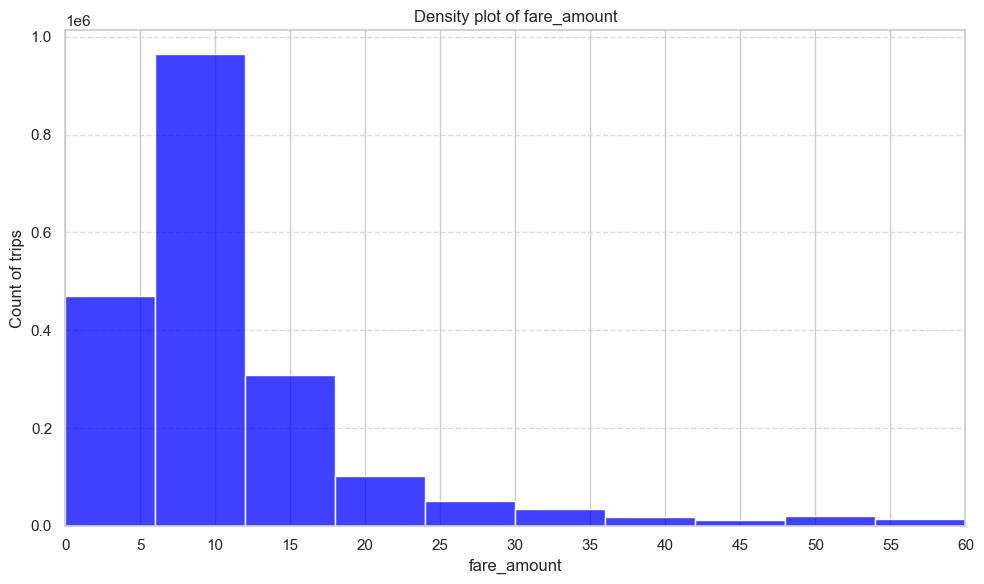

CPU times: user 900 ms, sys: 498 ms, total: 1.4 s
Wall time: 484 ms


In [ ]:
%%time
# sns histogram plot the number of trips with fare_amount between 0 and 60
plt.figure(figsize=(10, 6))
import seaborn as sns
sns.set(style="whitegrid")
sns.histplot(data = dfp,
            x=dfp['fare_amount'],
            bins=10,
            kde=False, 
            color='blue', 
            stat='count')
plt.xlim(0, 60)
plt.title('Density plot of fare_amount')
plt.xlabel('fare_amount')
plt.ylabel('Count of trips')
plt.xticks(np.arange(0, 61, 5))
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [ ]:
%%time
df[['fare_amount']].sum().compute()

CPU times: user 525 ms, sys: 133 ms, total: 658 ms
Wall time: 850 ms


fare_amount    22695577.52
dtype: float64

#### Observe the number of workers and cores running in your machine

Initialize a client and observe how many workers are working and the number of cores utilizing for the given data set.

In [17]:
%%time
""" Initialize a client """
# YOUR CODE HERE
from dask.distributed import LocalCluster, Client
#set up local cluster with 4 workers
cluster = LocalCluster(n_workers=4, threads_per_worker=1, memory_limit='2GB',dashboard_address='192.168.0.102:9995')


client = Client(cluster)


#client = cluster.get_client()
#perform a sanity check to see if the client is connected
print(client)
# Read the dataset using Dask with the specified dtype
clusterdf = dd.read_csv(FILENAME, dtype={'passenger_count': 'int64'})
clusterdf[['fare_amount']].sum().compute()
clusterdf.persist()
#client.close() #To do: move this to the end of the notebook


<Client: 'tcp://127.0.0.1:53016' processes=4 threads=4, memory=7.45 GiB>
CPU times: user 157 ms, sys: 97.3 ms, total: 255 ms
Wall time: 2.77 s


,Unnamed: 0,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
npartitions=3,,,,,,,,,
,int64,string,float64,string,float64,float64,float64,float64,int64
,...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...,...


In [ ]:
#Test code to generate a large Dask array and perform some operations in local cluster
#import dask.array as da
#arr = da.random.random((10000, 10000), chunks=(1000, 1000))
#result = (arr + arr.T - arr.mean(axis=0)).sum()
#result.compute()

In [ ]:
type(df)
clusterdf = dd.from_pandas(df, npartitions=4)
clusterdf['fare_amount'].sum().compute()


22695577.519999996

### EDA based on Time

#### Exercise 4: Extract day of the week (dow), hour, month and year from `pickup_datetime`. (1 Point)

**Hint:** use `pd.to_datetime()` function as dask does not have this functionality in it.

Remember to use `.compute()` while passing the dask dataframe in defined function.

In [ ]:
print (df.head(2))
print(df.dtypes)

   fare_amount          pickup_datetime  pickup_longitude  pickup_latitude  \
0          4.5  2009-06-15 17:26:21 UTC        -73.844311        40.721319   
1         16.9  2010-01-05 16:52:16 UTC        -74.016048        40.711303   

   dropoff_longitude  dropoff_latitude  passenger_count  
0         -73.841610         40.712278                1  
1         -73.979268         40.782004                1  
fare_amount                  float64
pickup_datetime      string[pyarrow]
pickup_longitude             float64
pickup_latitude              float64
dropoff_longitude            float64
dropoff_latitude             float64
passenger_count                int64
dtype: object


In [ ]:
#Function to take a dask dataframe and add 'dayof week', 'hour', 'month, 'year' columns
#use pandas to_datetime to convert 'pickup_datetime' to datetime

def add_datetime_features(df: dd.DataFrame) -> dd.DataFrame:
    print('Datatype inside add_datetime:',type(df))
    df['pickup_datetime'] = dd.to_datetime(df['pickup_datetime'])
    df['dayofweek'] = df['pickup_datetime'].dt.dayofweek
    df['hour'] = df['pickup_datetime'].dt.hour
    df['month'] = df['pickup_datetime'].dt.month
    df['year'] = df['pickup_datetime'].dt.year
    print('Datatype of df inside add_datetime before return:',type(df))
    return df


In [ ]:
%%time
# call the function to add datetime features for df
#use compute so the function is applied to the entire dask dataframe
#check how many workers are used in client.cluster

df_withDT = add_datetime_features(df).compute() #compute converts this to pandas dataframe
print('Datatype after add_datetime_features:', type(df_withDT))
print(client.cluster)
# print the first 2 rows of df_withDT
print(df_withDT.head(2))


Datatype inside add_datetime: <class 'dask.dataframe.dask_expr._collection.DataFrame'>
Datatype of df inside add_datetime before return: <class 'dask.dataframe.dask_expr._collection.DataFrame'>
Datatype after add_datetime_features: <class 'pandas.core.frame.DataFrame'>
LocalCluster(235e6095, 'tcp://127.0.0.1:50411', workers=4, threads=8, memory=8.00 GiB)
   fare_amount           pickup_datetime  pickup_longitude  pickup_latitude  \
0          4.5 2009-06-15 17:26:21+00:00        -73.844311        40.721319   
1         16.9 2010-01-05 16:52:16+00:00        -74.016048        40.711303   

   dropoff_longitude  dropoff_latitude  passenger_count  dayofweek  hour  \
0         -73.841610         40.712278                1          0    17   
1         -73.979268         40.782004                1          1    16   

   month  year  
0      6  2009  
1      1  2010  
CPU times: user 152 ms, sys: 140 ms, total: 292 ms
Wall time: 3.93 s


In [ ]:
#check if data frame is Dask DataFrame or pandas DataFrame
print(type(df))
print(type(df_withDT))

<class 'dask.dataframe.dask_expr._collection.DataFrame'>
<class 'pandas.core.frame.DataFrame'>


In [ ]:
#count of rows in df_withDT
print('Number of rows in df_withDT: ', len(df_withDT.index))

Number of rows in df_withDT:  2000000


#### Exercise 5: a.) Plot the taxi trip by hour of the day  (0.5 Points)

* Partition the data into segments using `dask.from_pandas()`

* Plot the taxi trip for hour of the day. **Hint:** [sns.catplot](https://seaborn.pydata.org/generated/seaborn.catplot.html)

In [ ]:
#partition the dataframe in to 10 segments using dask.from_pandas
num_segments = 10

df_withDT_part = dd.from_pandas(df_withDT, npartitions=num_segments)

In [ ]:
print (type(df_withDT_part))
#check the number of partitions
print('Number of partitions in df_withDT_part: ', df_withDT_part.npartitions)


<class 'dask.dataframe.dask_expr._collection.DataFrame'>
Number of partitions in df_withDT_part:  10


In [ ]:
#check the first 2 rows of each partition of df_withDT_part
#utility function to print first 2 rows of each partition with try-catch for empty partitions
def print_partition_head(df_part_to_print, nrows=2):
    try:
        num_part_print = df_part_to_print.npartitions
        for i in range(num_part_print):
            print(f'Partition {i}:')
            print(df_part_to_print.get_partition(i).head(nrows))
            print('\n')
    except ValueError as e:
        print(f'Error: {e}')
        print('This partition is empty or has no data to display.')


In [ ]:
df_withDT_part.dtypes

fare_amount                      float64
pickup_datetime      datetime64[ns, UTC]
pickup_longitude                 float64
pickup_latitude                  float64
dropoff_longitude                float64
dropoff_latitude                 float64
passenger_count                    int64
dayofweek                          int32
hour                               int32
month                              int32
year                               int32
dtype: object

In [ ]:
df_withDT_part = client.persist(df_withDT_part)  # Persist the Dask DataFrame to keep it in memory

In [ ]:
df_withDT_part.head(2)

,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,dayofweek,hour,month,year
0,4.5,2009-06-15 17:26:21+00:00,-73.844311,40.721319,-73.841610,40.712278,1,0,17,6,2009
0,7.7,2009-05-29 18:58:00+00:00,-74.006425,40.744747,-73.981225,40.769387,3,4,18,5,2009


In [ ]:
""" taxi trip repartition by hour of the day """
# Repartition the dask dataframe df_withDT_part by hour of the day
# This will create a new partition for each hour of the day
df_withDT_part['hour'] = df_withDT_part['hour'].astype('int64')  # Ensure 'hour' is of type int64
#df_withDT_part = df_withDT_part.set_index('hour', sorted=True)
df_withDT_part = df_withDT_part.repartition(npartitions=24)  # Repartition into 24 partitions for each hour

# Display the repartitioned dataframe
print('Repartitioned DataFrame by hour:',df_withDT_part.head(2))


Repartitioned DataFrame by hour:    fare_amount           pickup_datetime  pickup_longitude  pickup_latitude  \
0          4.5 2009-06-15 17:26:21+00:00        -73.844311        40.721319   
0          7.7 2009-05-29 18:58:00+00:00        -74.006425        40.744747   

   dropoff_longitude  dropoff_latitude  passenger_count  dayofweek  hour  \
0         -73.841610         40.712278                1          0    17   
0         -73.981225         40.769387                3          4    18   

   month  year  
0      6  2009  
0      5  2009  


In [ ]:
print_partition_head(df_withDT_part, nrows=1)
#To do: check how to avoid printing empty partitions, tuple out of range error from within utlity function in the try-catch block

Partition 0:
   fare_amount           pickup_datetime  pickup_longitude  pickup_latitude  \
0          4.5 2009-06-15 17:26:21+00:00        -73.844311        40.721319   

   dropoff_longitude  dropoff_latitude  passenger_count  dayofweek  hour  \
0          -73.84161         40.712278                1          0    17   

   month  year  
0      6  2009  


Partition 1:
       fare_amount           pickup_datetime  pickup_longitude  \
27777          8.0 2013-10-20 00:09:09+00:00         -73.96366   

       pickup_latitude  dropoff_longitude  dropoff_latitude  passenger_count  \
27777        40.774427         -73.970787         40.793421                1   

       dayofweek  hour  month  year  
27777          6     0     10  2013  


Partition 2:
       fare_amount           pickup_datetime  pickup_longitude  \
55555          6.5 2009-11-13 19:58:00+00:00        -74.000435   

       pickup_latitude  dropoff_longitude  dropoff_latitude  passenger_count  \
55555        40.742637      

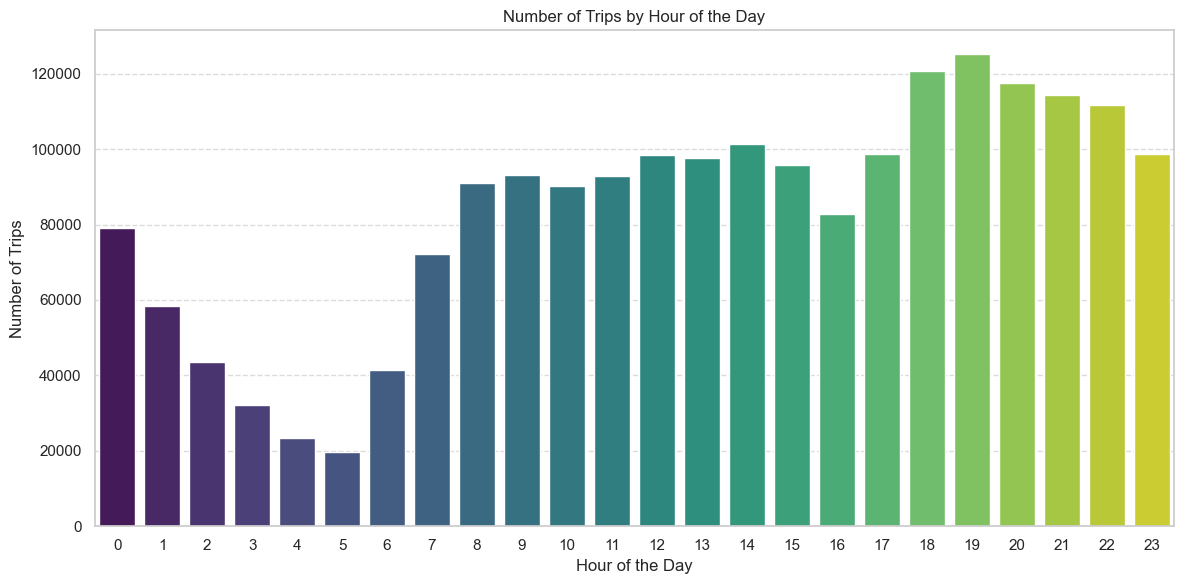

In [ ]:
#plot sns categorical plot of number of trips by hour of the day
plt.figure(figsize=(12, 6))
sns.set(style="whitegrid")
sns.countplot(data=df_withDT_part.compute(), x='hour', palette='viridis')
plt.title('Number of Trips by Hour of the Day')
plt.xlabel('Hour of the Day')
plt.ylabel('Number of Trips')
plt.xticks(np.arange(0, 24, 1))
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

#### Exercise 5: b.) Plot the taxi trip repartition by day of the week (dow) (0.5 Points)

In [ ]:
df_withDT_part.head(2)

,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,dayofweek,hour,month,year
0,4.5,2009-06-15 17:26:21+00:00,-73.844311,40.721319,-73.841610,40.712278,1,0,17,6,2009
0,7.7,2009-05-29 18:58:00+00:00,-74.006425,40.744747,-73.981225,40.769387,3,4,18,5,2009


In [ ]:
""" taxi trip repartition by day of the week """
# YOUR CODE HERE
# Repartition the dask dataframe df_withDT_part by day of the week without losing the 'hour' column
df_withDT_part['dayofweek'] = df_withDT_part['dayofweek'].astype('int64')  # Ensure 'dayofweek' is of type int64
#df_withDT_part = df_withDT_part.set_index('dayofweek', sorted=True)
df_withDT_part = df_withDT_part.repartition(npartitions=7)  # Repartition into 7 partitions for each day of the week
# Display the repartitioned dataframe
print('Repartitioned DataFrame by day of the week:', df_withDT_part.head(2))


Repartitioned DataFrame by day of the week:    fare_amount           pickup_datetime  pickup_longitude  pickup_latitude  \
0          4.5 2009-06-15 17:26:21+00:00        -73.844311        40.721319   
0          7.7 2009-05-29 18:58:00+00:00        -74.006425        40.744747   

   dropoff_longitude  dropoff_latitude  passenger_count  dayofweek  hour  \
0         -73.841610         40.712278                1          0    17   
0         -73.981225         40.769387                3          4    18   

   month  year  
0      6  2009  
0      5  2009  


In [ ]:
print_partition_head(df_withDT_part, nrows=1)

Partition 0:
   fare_amount           pickup_datetime  pickup_longitude  pickup_latitude  \
0          4.5 2009-06-15 17:26:21+00:00        -73.844311        40.721319   

   dropoff_longitude  dropoff_latitude  passenger_count  dayofweek  hour  \
0          -73.84161         40.712278                1          0    17   

   month  year  
0      6  2009  


Partition 1:
       fare_amount           pickup_datetime  pickup_longitude  \
83332          5.7 2012-06-03 18:22:48+00:00        -73.955373   

       pickup_latitude  dropoff_longitude  dropoff_latitude  passenger_count  \
83332        40.779669         -73.967088         40.788538                1   

       dayofweek  hour  month  year  
83332          6    18      6  2012  


Partition 2:
        fare_amount           pickup_datetime  pickup_longitude  \
166666         12.0 2014-12-13 02:58:00+00:00         -73.98841   

        pickup_latitude  dropoff_longitude  dropoff_latitude  passenger_count  \
166666          40.7483  

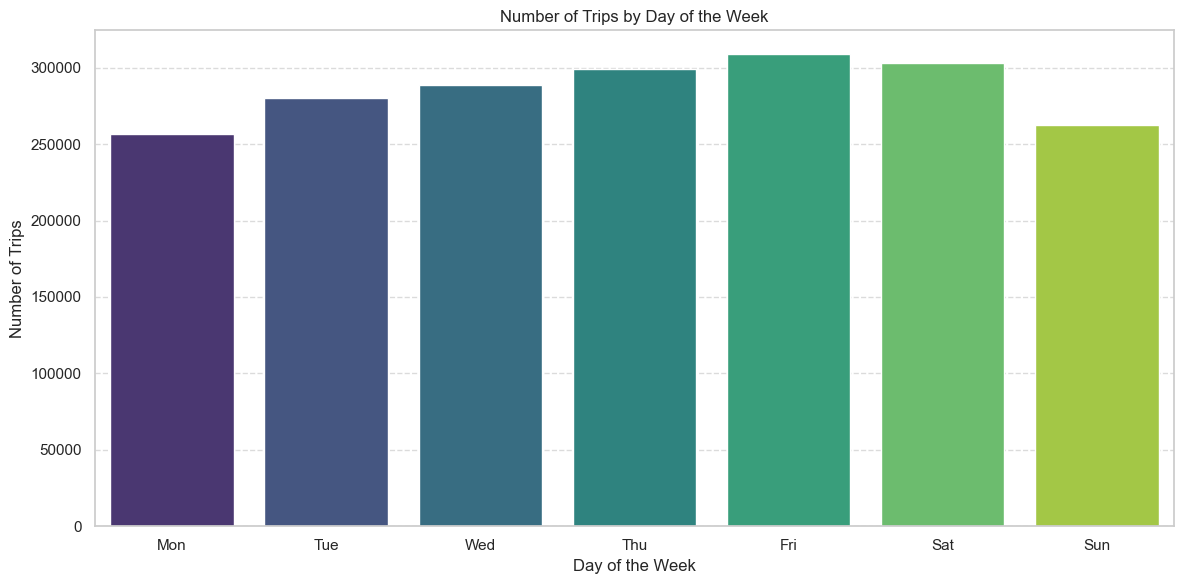

In [ ]:
#plot sns categorical plot of number of trips by day of the week
plt.figure(figsize=(12, 6))
sns.set(style="whitegrid")
sns.countplot(data=df_withDT_part.compute(), x='dayofweek', palette='viridis')
plt.title('Number of Trips by Day of the Week')
plt.xlabel('Day of the Week')
plt.ylabel('Number of Trips')
plt.xticks(np.arange(0, 7, 1), ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

#### Exercise 6: a.) Draw a plot between the target variable and passenger count and analyze it.  (0.5 Points)

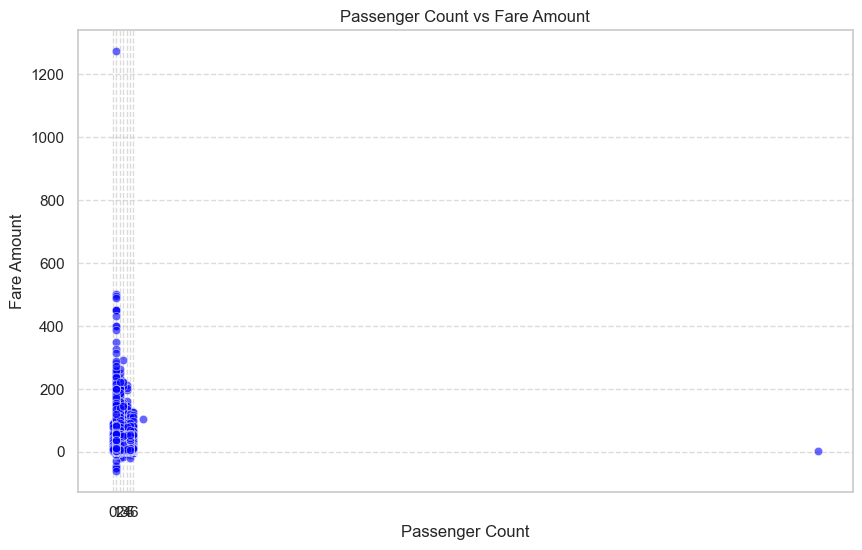

In [ ]:
""" passenger count feature """
#scatter plot of passenger_count vs fare_amount
plt.figure(figsize=(10, 6))
sns.set(style="whitegrid")
sns.scatterplot(data=df_withDT_part.compute(), x='passenger_count', y='fare_amount', alpha=0.6, color='blue')
plt.title('Passenger Count vs Fare Amount')
plt.xlabel('Passenger Count')
plt.ylabel('Fare Amount')
plt.xticks(np.arange(0, 7, 1))
plt.grid(True, linestyle='--', alpha=0.7)
#plt.tight_layout()
plt.show()


2025-05-25 09:01:19,819 - distributed.worker - ERROR - failed during get data with tcp://127.0.0.1:50425 -> tcp://127.0.0.1:50422
Traceback (most recent call last):
  File "/Users/achappa/Library/Python/3.12/lib/python/site-packages/tornado/iostream.py", line 962, in _handle_write
    num_bytes = self.write_to_fd(self._write_buffer.peek(size))
                ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/achappa/Library/Python/3.12/lib/python/site-packages/tornado/iostream.py", line 1124, in write_to_fd
    return self.socket.send(data)  # type: ignore
           ^^^^^^^^^^^^^^^^^^^^^^
OSError: [Errno 55] No buffer space available

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/distributed/worker.py", line 1795, in get_data
    response = await comm.read(deserializers=serializers)
               ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

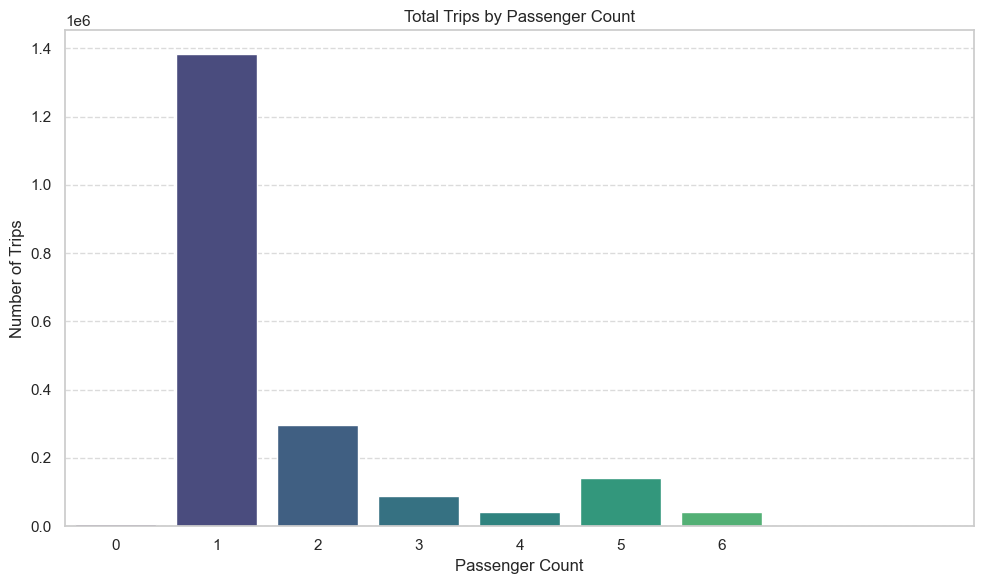

In [ ]:
#plot the total trips by passenger count
plt.figure(figsize=(10, 6))
sns.set(style="whitegrid")
sns.countplot(data=df_withDT_part.compute(), x='passenger_count', palette='viridis')
plt.title('Total Trips by Passenger Count')
plt.xlabel('Passenger Count')
plt.ylabel('Number of Trips')
plt.xticks(np.arange(0, 7, 1))
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [ ]:
#print the number of trips per unique passenger counts sorted by passenger count ascending  
passenger_count_counts = df_withDT_part['passenger_count'].value_counts().compute().sort_index()
print('Number of trips per unique passenger counts sorted by passenger count ascending:', passenger_count_counts)



Number of trips per unique passenger counts sorted by passenger count ascending: passenger_count
0         7123
1      1383192
2       295881
3        87652
4        42654
5       141493
6        42003
9            1
208          1
Name: count, dtype: int64


#### Exercise 6: b.) Draw a plot between the target variable and hour and analyze it. (0.5 Points)

In [ ]:
df_withDT_part.dtypes

fare_amount                      float64
pickup_datetime      datetime64[ns, UTC]
pickup_longitude                 float64
pickup_latitude                  float64
dropoff_longitude                float64
dropoff_latitude                 float64
passenger_count                    int64
dayofweek                          int64
hour                               int64
month                              int32
year                               int32
dtype: object

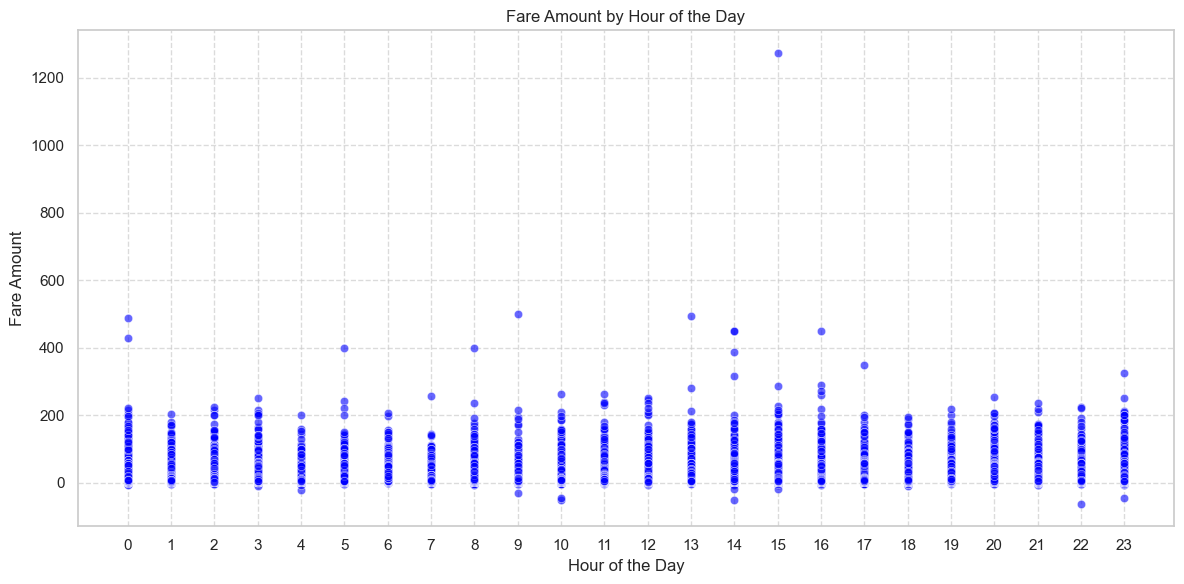

In [ ]:
""" fare amount by hour """
# draw scatter plot of fare_amount by hour
plt.figure(figsize=(12, 6))
sns.set(style="whitegrid")
sns.scatterplot(data=df_withDT_part.compute(), x='hour', y='fare_amount', alpha=0.6, color='blue')
plt.title('Fare Amount by Hour of the Day')
plt.xlabel('Hour of the Day')
plt.ylabel('Fare Amount')
plt.xticks(np.arange(0, 24, 1))
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


### Feature Engineering

#### Exercise 7: Compute the Haversine distance between pickup and dropoff point. (1 Point)

* Convert the latitude and longitude co-rodinates to radians

* Calculate the Haversine distance

  **Hint:** [haversine_distances](https://towardsdatascience.com/heres-how-to-calculate-distance-between-2-geolocations-in-python-93ecab5bbba4)

* Add the "distance" feature to the dataset and plot its distribution

In [ ]:
#calculate haversine distance (great circle distance) between two lat-long
def haversine_distance(lat1, lon1, lat2, lon2):
   r = 6371
   phi1 = np.radians(lat1)
   phi2 = np.radians(lat2)
   delta_phi = np.radians(lat2 - lat1)
   delta_lambda = np.radians(lon2 - lon1)
   a = np.sin(delta_phi / 2)**2 + np.cos(phi1) * np.cos(phi2) *   np.sin(delta_lambda / 2)**2
   res = r * (2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a)))
   return np.round(res, 2)

In [ ]:
#Test haversine distance function with two locations
start_lat, start_lon = 40.6976637, -74.1197643 #NYC
end_lat, end_lon = 39.764519, -104.995195   #Denver

#13.0832° N, 80.2755° E
start_lat, start_lon = 13.0832, 80.2755 #Chennai Central
#end_lat, end_lon = 13.0827, 80.2707   #Chennai Marina
end_lat,end_lon = 12.9781, 77.5695 #KSR Bengaluru

# haversine distance
dist = haversine_distance(start_lat, start_lon, end_lat, end_lon)
print(f"Distance between start and end is {dist} km")

Distance between start and end is 293.38 km


In [ ]:
df_withDT_part.dtypes

fare_amount                      float64
pickup_datetime      datetime64[ns, UTC]
pickup_longitude                 float64
pickup_latitude                  float64
dropoff_longitude                float64
dropoff_latitude                 float64
passenger_count                    int64
dayofweek                          int64
hour                               int64
month                              int32
year                               int32
dtype: object

In [ ]:
type(df_withDT_part)

pandas.core.frame.DataFrame

In [ ]:
# add distance column to the dask dataframe df_withDT_part
#compute the distance by using the haversine_distance function on each row, apply lanbda function
df_withDT_part['distance'] = df_withDT_part.apply(lambda x:
                                haversine_distance(x['pickup_latitude'], 
                                                   x['pickup_longitude'], 
                                                   x['dropoff_latitude'], 
                                                   x['dropoff_longitude']), 
                                                   axis=1
                                                )
#df_withDT_part = df_withDT_part.compute()  # Convert to pandas DataFrame (dont do compute...retain dask dataframe)
print('Datatype after adding distance column:', type(df_withDT_part))
# check the first 2 rows of df_withDT_part
print(df_withDT_part.head(2))


Datatype after adding distance column: <class 'pandas.core.frame.DataFrame'>
   fare_amount           pickup_datetime  pickup_longitude  pickup_latitude  \
0          4.5 2009-06-15 17:26:21+00:00        -73.844311        40.721319   
0          7.7 2009-05-29 18:58:00+00:00        -74.006425        40.744747   

   dropoff_longitude  dropoff_latitude  passenger_count  dayofweek  hour  \
0         -73.841610         40.712278                1          0    17   
0         -73.981225         40.769387                3          4    18   

   month  year  distance  
0      6  2009      1.03  
0      5  2009      3.47  


In [ ]:
df_withDT_part.dtypes

fare_amount                      float64
pickup_datetime      datetime64[ns, UTC]
pickup_longitude                 float64
pickup_latitude                  float64
dropoff_longitude                float64
dropoff_latitude                 float64
passenger_count                    int64
dayofweek                          int64
hour                               int64
month                              int32
year                               int32
distance                         float64
dtype: object

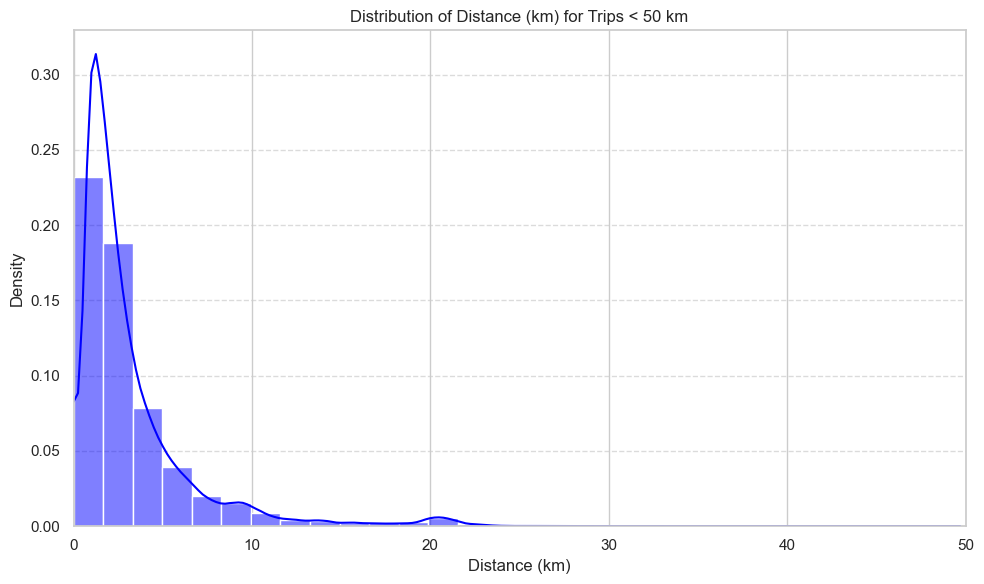

In [ ]:
""" plot the distance feature (take distance < 50) """
# YOUR CODE HERE
# Filter the DataFrame for distance < 50 km
df_distance_filtered = df_withDT_part[df_withDT_part['distance'] < 50]
# Plot the distance feature
plt.figure(figsize=(10, 6))
sns.set(style="whitegrid")
sns.histplot(data=df_distance_filtered, x='distance', bins=30, kde=True, color='blue', stat='density')
plt.title('Distribution of Distance (km) for Trips < 50 km')
plt.xlabel('Distance (km)')
plt.ylabel('Density')
plt.xlim(0, 50)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


### Show the plot between distance and fare amount

**Hint:** [sns.scatterplot()](https://seaborn.pydata.org/generated/seaborn.scatterplot.html)

In [ ]:
correlation = df_withDT_part['fare_amount'].corr(df_withDT_part['distance'])
print(f'Correlation between fare_amount and distance: {correlation:.2f}')

Correlation between fare_amount and distance: 0.02


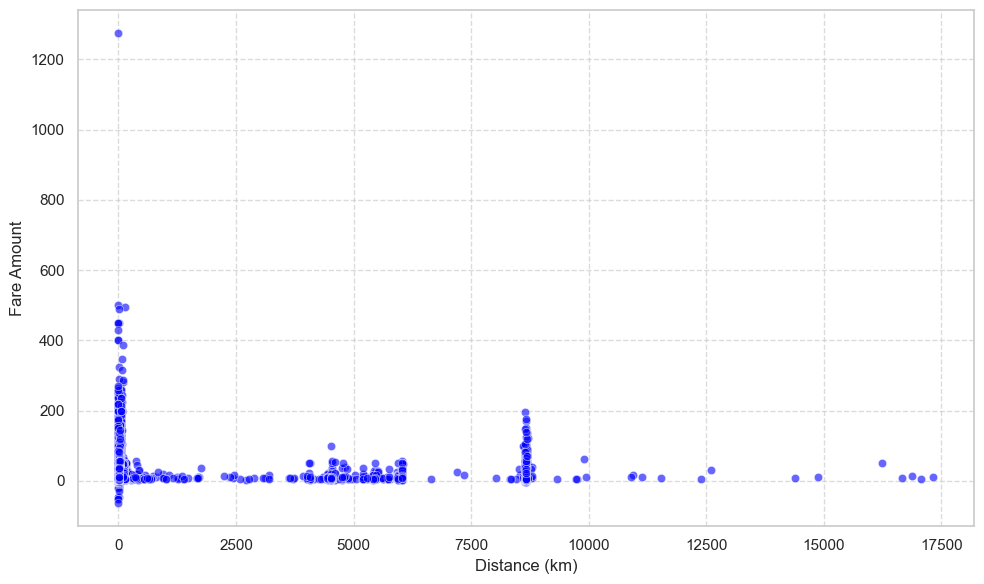

In [ ]:
""" correlation between fare_amount and distance """
# YOUR CODE HERE
df_plot=df_withDT_part.reset_index(drop=True)  # Reset index to avoid dupe index issues with plotting

# scatter plot of fare_amount vs distance (x axis) with alpha=0.6
plt.figure(figsize=(10, 6))
sns.set(style="whitegrid")
sns.scatterplot(data=df_plot, 
                x='distance', 
                y='fare_amount', 
                alpha=0.6, 
                color='blue')
#plt.title('Correlation between Fare Amount and Distance')
plt.xlabel('Distance (km)')
plt.ylabel('Fare Amount')
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


In [ ]:
#number of trips less than 50 km
unique_distances = df_withDT_part[df_withDT_part['distance'] < 50]['distance'].shape[0]
print(f'Number of trips less than 50 km: {unique_distances}')

#number of trips  with distance less than 100 km
num_trips_distance_less_100 = df_withDT_part[df_withDT_part['distance'] < 100].shape[0]
print(f'Number of trips with distance less than 100 km: {num_trips_distance_less_100}')

#number of trips with distance between 50 and 100 km
num_trips_distance_50_to_100 = df_withDT_part[(df_withDT_part['distance'] >= 50) & (df_withDT_part['distance'] < 100)].shape[0]
print(f'Number of trips with distance between 50 and 100 km: {num_trips_distance_50_to_100}')

#max distance
max_distance = df_withDT_part['distance'].max()
print(f'Maximum distance in the dataset: {max_distance:.2f} km')

num_trips_distance_gt_100 = df_withDT_part[df_withDT_part['distance'] > 100].shape[0]
print(f'Number of trips with distance greater than 100 km: {num_trips_distance_gt_100}')


Number of trips less than 50 km: 1995183
Number of trips with distance less than 100 km: 1995511
Number of trips with distance between 50 and 100 km: 328
Maximum distance in the dataset: 17330.20 km
Number of trips with distance greater than 100 km: 4475


### Preparing dataset for model implementation

**Note:** Use the above modified dataset for modelling.

In [ ]:
print(type(df_plot))

<class 'pandas.core.frame.DataFrame'>


In [ ]:
# YOUR CODE HERE
# create a new dask dataframe df_plot

df_Model = dd.from_pandas(df_plot, npartitions=10)
# check the first 2 rows of df_Model
print('First 2 rows of df_Model:', df_Model.head(2))

### Removing outliers from training set Based on Coordinates

#### Exercise 8: Remove the outliers using the given latitude and longitude features from the dataset. We need to analyze the data of taxi within New York City. (1 Point)

**Hint:** Given the co-ordinates of New York city are Latitude: 40.7128° and Longitude: -74.0060°. You can include the pickup and drop off points such that there left and right value mean will be the given co-ordinate value.

Also, choose nearest extreme values.

Use `.between()` and pass left and right value attributes accordingly.

In [ ]:
""" remove the outliers in pickup latitude longitude and drop off latitude and longitude """
#NOT USED CELL
# Create a function that checks if pickup or dropoff latitude and longitude is within 10km from the NYC coordinates (Latitude: 40.7128° and Longitude: -74.0060°)
# use haversine distance function
def is_within_nyc(lat, lon,threshold) -> bool:
    nyc_lat, nyc_lon = 40.7128, -74.0060  # NYC coordinates
    distance = haversine_distance(lat, lon, nyc_lat, nyc_lon)
    return distance <= threshold  # Check if within 10 km of NYC
# Apply the function to filter the DataFrame
threshold = 10  # 10 km threshold
df_Model = df_Model[df_Model.apply(lambda x: is_within_nyc(x['pickup_latitude'], x['pickup_longitude'], threshold) and 
                                      is_within_nyc(x['dropoff_latitude'], x['dropoff_longitude'], threshold), 
                                      axis=1, meta=('valid', 'bool'))]
# Check the first 2 rows of the filtered DataFrame
print('First 2 rows of df_Model after filtering:', df_Model.head(2))

First 2 rows of df_Model after filtering:    fare_amount           pickup_datetime  pickup_longitude  pickup_latitude  \
1          7.7 2009-05-29 18:58:00+00:00        -74.006425        40.744747   
2         91.0 2014-09-21 10:02:20+00:00        -74.009455        40.724818   

   dropoff_longitude  dropoff_latitude  passenger_count  dayofweek  hour  \
1         -73.981225         40.769387                3          4    18   
2         -73.965932         40.638384                1          6    10   

   month  year  distance  
1      5  2009      3.47  
2      9  2014     10.29  


In [ ]:
#This is the dd dataframe with outliers removed (from Aashish's code,)
nyc_df = df_Model[
    df_Model['pickup_latitude'].between(40.5, 41.0) &
    df_Model['pickup_longitude'].between(-74.3, -73.7) &
    df_Model['dropoff_latitude'].between(40.5, 41.0) &
    df_Model['dropoff_longitude'].between(-74.3, -73.7) &
    df_Model['fare_amount'].between(1, 100) &  # Reasonable fare range
    df_Model['distance'].between(0.1, 50)  # Reasonable distance range
]

print(f"Dataset after outlier removal: {nyc_df.shape}")

Dataset after outlier removal: (<dask_expr.expr.Scalar: expr=(Filter(frame=df, predicate=Between(frame=df['pickup_latitude'], left=40.5, right=41.0) & Between(frame=df['pickup_longitude'], left=-74.3, right=-73.7) & Between(frame=df['dropoff_latitude'], left=40.5, right=41.0) & Between(frame=df['dropoff_longitude'], left=-74.3, right=-73.7) & Between(frame=df['fare_amount'], left=1, right=100) & Between(frame=df['distance'], left=0.1, right=50))).size() // 12, dtype=int64>, 12)


In [ ]:
nyc_df.head(2)
#print number of rows in nyc_df
print(f"Number of rows in nyc_df: {len(nyc_df.index)}")

Number of rows in nyc_df: 1924227


In [ ]:
type(nyc_df)

dask.dataframe.dask_expr._collection.DataFrame

### Modelling

#### Exercise 9: Divide the data into train and test splits with X as feature variables and y as target variable  (1 Point)

* Divide data into train test split with 70-30 ratio, Hint: `train_test_split()`

* As dask functions operate lazily so, before calling `.fit()` function, call the dask dataframe with `.compute()`.
* Convert X_train and y_train into array using `.values` as [dask's](https://ml.dask.org/modules/api.html) `.fit()` function takes array as attribute

In [ ]:
""" select the target and feature variables and split the data into train and test """
# YOUR CODE HERE
# Select target and feature variables
target = 'fare_amount'
features = ['pickup_latitude', 'pickup_longitude', 'dropoff_latitude', 'dropoff_longitude', 
            'passenger_count', 'dayofweek', 'hour', 'month', 'year', 'distance']
# discuss if we need latitude and longitude as features or not? To do
# Split the data into train and test sets
X = nyc_df[features]
y = nyc_df[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
# Check the shapes of the train and test sets
print(f'Train set shape: {X_train.shape}, Test set shape: {X_test.shape}')
# Check the first 2 rows of the train set
print('First 2 rows of X_train:', X_train.head(2))
# Check the first 2 rows of the test set
print('First 2 rows of X_test:', X_test.head(2))
# Check the first 2 rows of y_train
print('First 2 rows of y_train:', y_train.head(2))

Train set shape: (<dask_expr.expr.Scalar: expr=(SplitTake(frame=Split(frame=(Filter(frame=df, predicate=Between(frame=df['pickup_latitude'], left=40.5, right=41.0) & Between(frame=df['pickup_longitude'], left=-74.3, right=-73.7) & Between(frame=df['dropoff_latitude'], left=40.5, right=41.0) & Between(frame=df['dropoff_longitude'], left=-74.3, right=-73.7) & Between(frame=df['fare_amount'], left=1, right=100) & Between(frame=df['distance'], left=0.1, right=50)))[['pickup_latitude', 'pickup_longitude', 'dropoff_latitude', 'dropoff_longitude', 'passenger_count', 'dayofweek', 'hour', 'month', 'year', 'distance']], frac=[0.7, 0.3], random_state=1608637542, shuffle=False), i=0, ndim=2)).size() // 10, dtype=int64>, 10), Test set shape: (<dask_expr.expr.Scalar: expr=(SplitTake(frame=Split(frame=(Filter(frame=df, predicate=Between(frame=df['pickup_latitude'], left=40.5, right=41.0) & Between(frame=df['pickup_longitude'], left=-74.3, right=-73.7) & Between(frame=df['dropoff_latitude'], left=40.5

#### Exercise 10: Predict the test data and calculate the mean squared error and r2 score. (1 Point)

**Hint:** Remember to call `.compute()` function as dask functions operate lazily and convert the dask dataframe to `.values` (Array type) as suggested in above exercise

In [ ]:
type(X_train)

dask.dataframe.dask_expr._collection.DataFrame

In [ ]:
type(y_train)


dask.dataframe.dask_expr._collection.Series

In [ ]:
""" predict the values """
#X and y are dask dataframes, convert them to numpy arrays using .compute()
X_train_array = X_train.compute().values
y_train_array = y_train.compute().values

#fit a linear regression model using dask_ml
model = LinearRegression()
# Fit the model to the training data
#model.fit(X_train_array, y_train_array)
#convert X_train and y_train to dask arrays
X_train.persist()
y_train.persist()


model.fit(X_train.values, y_train.values)


2025-05-25 12:03:12,667 - distributed.nanny - ERROR - Worker process died unexpectedly


LinearRegression()

In [ ]:
#predict the values on the test set
X_test_array = X_test.compute().values
y_test_array = y_test.compute().values

y_pred = model.predict(X_test_array) 

In [ ]:
""" compute mean squared error and r2_score """
# YOUR CODE HERE
from sklearn.metrics import mean_squared_error, r2_score # Import from scikit-learn


mse = mean_squared_error(y_test_array, y_pred)

r2 = r2_score(y_test_array, y_pred)

print(f'Mean Squared Error: {mse:.4f}')
print(f'R^2 Score: {r2:.4f}')

Mean Squared Error: 14.8094
R^2 Score: 0.8251


### Report Analysis
* Discuss the pros and cons of using dask
* Derive the insights and discuss
* Comment on the performance metrics (MSE, $R^2$ score)


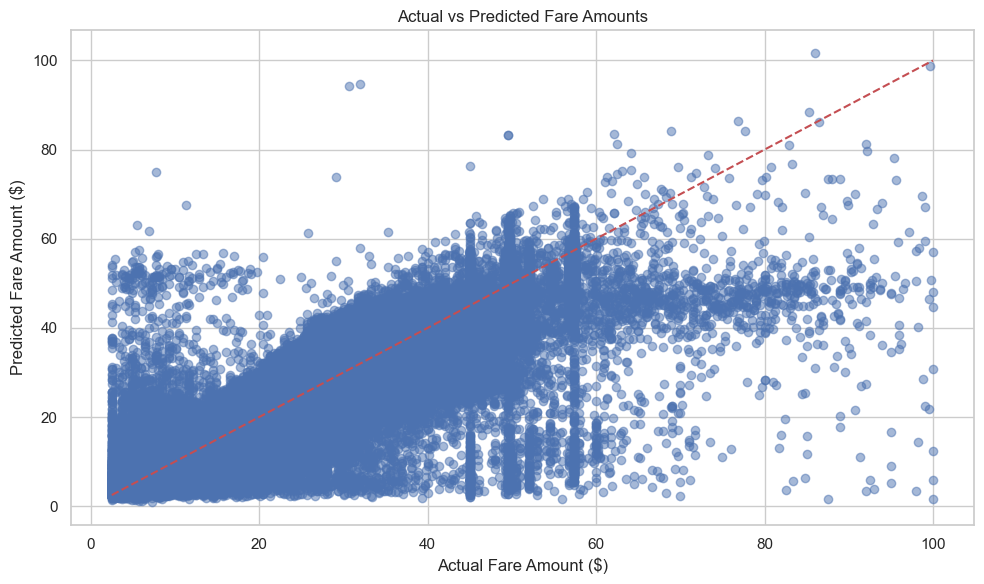

Taxi Fare Prediction Model Complete!


In [ ]:
# Plot actual vs predicted values
plt.figure(figsize=(10, 6))
plt.scatter(y_test_array, y_pred, alpha=0.5)
plt.plot([min(y_test_array), max(y_test_array)], [min(y_test_array), max(y_test_array)], 'r--')
plt.title('Actual vs Predicted Fare Amounts')
plt.xlabel('Actual Fare Amount ($)')
plt.ylabel('Predicted Fare Amount ($)')
plt.tight_layout()
plt.show()

print("Taxi Fare Prediction Model Complete!")